In [1]:
import os
import gc
import glob
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('../input/rangerdeeplearningoptimizer/ranger')
import timm
import wandb
# from ranger import Ranger

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# class Mish_layer(nn.Module):
#     '''
#     The class defines the Mish activation function.
#     '''
#     def __init__(self):
#         super(Mish_layer,self).__init__()
#     def forward(self,x):
#         return x*torch.tanh(F.softplus(x))

In [3]:
def set_seed(seed):
    #Sets the seed for Reprocudibility
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
set_seed(7)

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb") 

wandb.login(key = wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
config = dict(
    batch_size = 256,
    epochs = 100,
    learning_rate = 3e-4
    )

In [6]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)

    data = []
    for img_path in tqdm(root_list):
        data.append(img_path)
        
    return data

In [7]:
data_root_dir = r'../input/gsocml4scimodel3/Model_III/no_sub/*'
dataset_img_paths_list = img_paths_list(data_root_dir)

test_data_root_dir = r'../input/gsocml4scimodel3test/Model_III_test/no_sub/*'
test_paths_list = img_paths_list(test_data_root_dir)

# #this file was not being read by numpy
# dataset_img_paths_list.remove('../input/gsocml4scimodel8or9/reg_axion/sim_10205913971171895758427970222342137331.npy')

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
val_split = int(0.07 * len(dataset_img_paths_list))

random.shuffle(dataset_img_paths_list)

val_paths_list = dataset_img_paths_list[:val_split]
train_paths_list = dataset_img_paths_list[val_split:]

assert len(dataset_img_paths_list) == (len(train_paths_list) + len(val_paths_list))

len(train_paths_list), len(val_paths_list), len(test_paths_list)

(27900, 2100, 5000)

In [9]:
train_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 50, width = 50, p = 1.0),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Rotate(limit = 360, p = 0.4),
                ToTensorV2()
            ]
        )


test_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 50, width = 50, p = 1.0),
                ToTensorV2()
            ]
        )

In [10]:
def pickelize_file(dicto, pickle_path):
    file_to_write = open(pickle_path, "wb")
    pickle.dump(dicto, file_to_write)
    
    print("Pickleized successfully!")
    
pickelize_file(train_paths_list, "train_paths_list.pickle")
pickelize_file(val_paths_list, "val_paths_list.pickle")

Pickleized successfully!
Pickleized successfully!


In [11]:
class CustomDataset(Dataset):
    def __init__(self, paths_list, transform = None):

        self.transform = transform
        self.data = paths_list
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.data[idx]
        img = np.load(path, allow_pickle = True)
        img = (img - np.min(img))/(np.max(img) - np.min(img))

       
        if self.transform:
            aug = self.transform(image = img)
            img = aug['image']
        
        img = img.to(torch.float)        

        return img

In [12]:
train_dataset = CustomDataset(train_paths_list, transform = train_transforms)
print(len(train_dataset))

val_dataset = CustomDataset(val_paths_list, transform = test_transforms)
print(len(val_dataset))

test_dataset = CustomDataset(test_paths_list, transform = test_transforms)
print(len(test_dataset))

27900
2100
5000


In [13]:
train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)

In [14]:
single_batch = next(iter(train_loader))
single_batch.shape

torch.Size([256, 1, 64, 64])

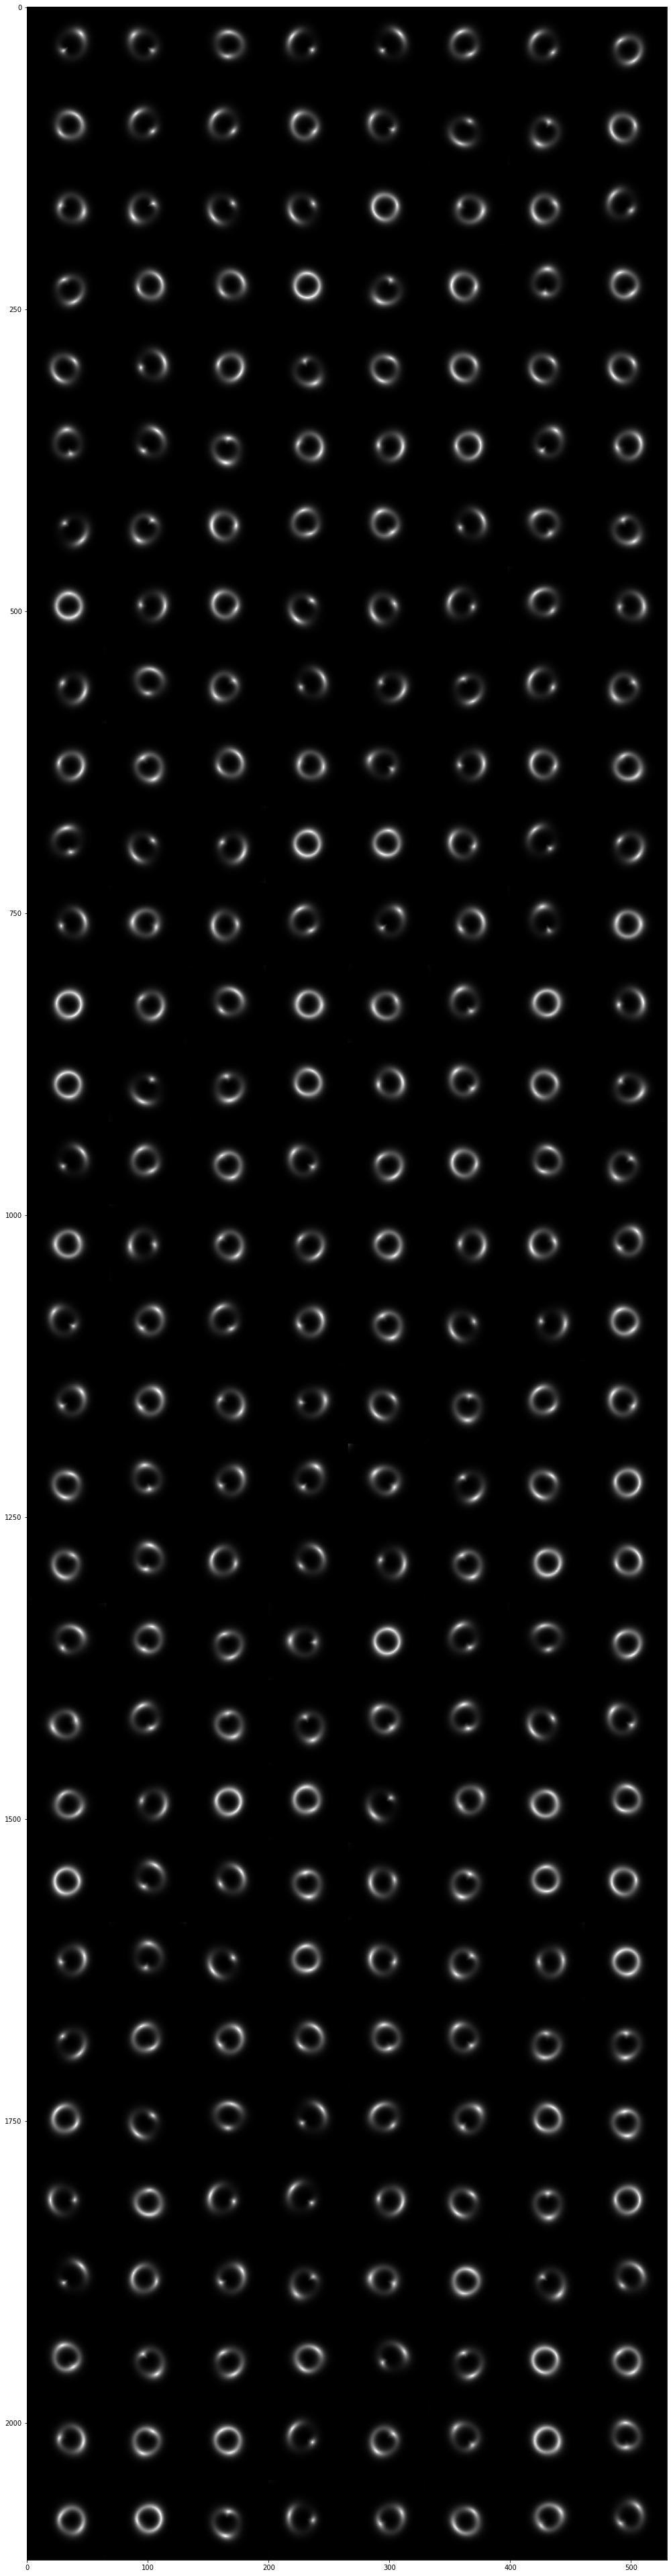

In [15]:
single_batch_grid = utils.make_grid(single_batch, nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [16]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels = 1, latent_dim = 2048):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size=2, stride = 2),
            nn.BatchNorm2d(64),
            nn.PReLU(),

            nn.Conv2d(64, 32, 2, stride=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            
            nn.Conv2d(32, 16, 2, stride=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            
            nn.Conv2d(16, 8, 2, stride=1),
            nn.BatchNorm2d(8),
            nn.PReLU()
        )

#         self.fc=nn.Sequential(
#             nn.Linear(64 * 61 * 61,512),
#             Mish_layer()
#         )

        self.bottleneck = nn.Sequential(
            nn.Linear(6728, latent_dim),
            nn.PReLU()
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.view(x.shape[0],-1)
#         x = self.fc(x)
        x = self.bottleneck(x)
        return x

In [17]:
class Decoder(nn.Module):
    
    def __init__(self, out_channels = 1, latent_dim = 2048):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dim, 6728),
            nn.PReLU()
        )

        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 2, stride = 1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            
            nn.ConvTranspose2d(16, 32, 2, stride = 1),
            nn.BatchNorm2d(32),
            nn.PReLU(),

            nn.ConvTranspose2d(32, 64, 2, stride = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            
            nn.ConvTranspose2d(64, out_channels, 2, stride = 2),
#             nn.UpsamplingBilinear2d(size=(256,256))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = x.view(x.shape[0], 8, 29, 29)
        x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
        return x

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder(in_channels = 1)
        self.dec = Decoder(out_channels = 1)

    def forward(self,x):
        encoded = self.enc(x)
        z = self.dec(encoded)

        return z

In [19]:
x = torch.randn(config["batch_size"], 1, 64, 64)
model = Autoencoder()
print(model(x).shape)

del model, x 
gc.collect()

torch.Size([256, 1, 64, 64])


209

In [20]:
def train_epoch(model, dataloader, criterion, optimizer, example_ct):
    
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, img_batch in loop:

        X = img_batch.to(device)

        example_ct += len(img_batch)
        
        #forward prop
        y_pred = model(X)
        
        #loss calculation
        loss = criterion(y_pred, X)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss), example_ct

In [21]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    losses = []
    
    y_pred_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, img_batch in loop:
            X = img_batch.to(device)
            y_truth_list.append(X.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            
            y_pred_list.append(y_pred.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, X)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            losses.append(loss.detach().cpu().numpy())

            
    return y_pred_list, y_truth_list, np.mean(losses)

In [22]:
def plot_ae_outputs(model,dataset,epoch, n = 10):
    
    model.eval()
    plt.figure(figsize=(16,4.5))
    random_index = random.randint(0,len(dataset) - (n + 1)) 
    
    
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = dataset[random_index + i].unsqueeze(0).to(device)


        with torch.no_grad():
            rec_img = model(img)
            
        img = img.permute(0,2,3,1)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(2, n, i + 1 + n)
        rec_img = rec_img.permute(0,2,3,1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plot_name = f"Reconstructions"
    plt.savefig(plot_name, format="png", dpi=80)  
    pic = Image.open(plot_name)
    
    wandb.log({plot_name: [wandb.Image(pic, caption = f"Epoch : {epoch+1}")]})
            
    plt.show()   

In [23]:
def fit_model(model, config):
    
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        EPOCHS = config.epochs
        LR = config.learning_rate
        optimizer = optim.Adam(model.parameters(), lr = LR)
#         scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 10, T_mult = 1,eta_min = 1e-6, verbose=True)
        criterion = nn.MSELoss()

        loss_dict = {'train_loss':[],'val_loss':[]}
        example_ct = 0  # number of examples seen

        wandb.watch(model, criterion, log="all", log_freq = 10)
        for epoch in range(EPOCHS):
            print(f"Epoch {epoch+1}/{EPOCHS}:")
            model, train_loss, example_ct = train_epoch(model, train_loader, criterion, optimizer, example_ct)
            _, _, val_loss = test_epoch(model, val_loader, criterion)
#             scheduler.step()

            print(f'Train loss:{train_loss}, Val loss:{val_loss}')
            wandb.log({"epoch": epoch + 1, "train_loss":train_loss, "val_loss": val_loss}, step = example_ct)

            loss_dict['train_loss'].append(train_loss)
            loss_dict['val_loss'].append(val_loss)

            if epoch % 5 == 0 or epoch + 1 == EPOCHS:
                plot_ae_outputs(model, val_dataset, epoch,10)


        return model, loss_dict

In [24]:
wandb.init(project="gsoc_model3-AD", config = config)

wandb: Currently logged in as: saranga7. Use `wandb login --relogin` to force relogin


In [25]:
model = Autoencoder().to(device)

Epoch 1/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.09146502614021301, Val loss:0.00470265606418252


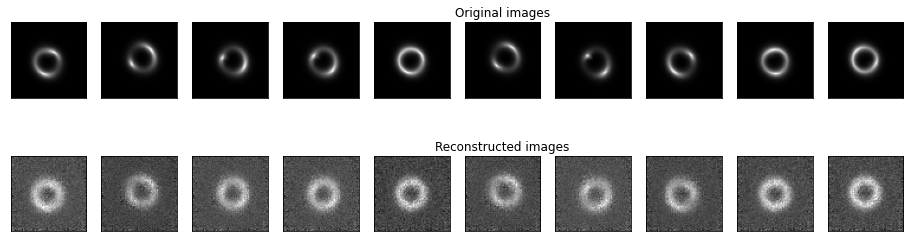

Epoch 2/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.003142689587548375, Val loss:0.0020629940554499626
Epoch 3/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.001650524791330099, Val loss:0.0011928204912692308
Epoch 4/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0010777818970382214, Val loss:0.0008214691770263016
Epoch 5/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0008027540170587599, Val loss:0.0006213057204149663
Epoch 6/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0006420693825930357, Val loss:0.0004885787493549287


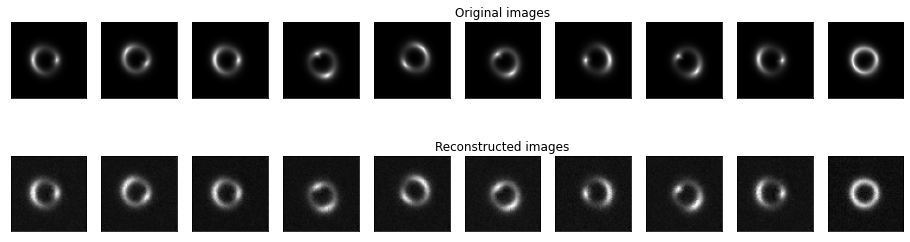

Epoch 7/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0005310131818987429, Val loss:0.00040706017171032727
Epoch 8/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0004597444203682244, Val loss:0.00034395980765111744
Epoch 9/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00040120462654158473, Val loss:0.0003016767150256783
Epoch 10/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0003562698548194021, Val loss:0.0002623875916469842
Epoch 11/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000328161841025576, Val loss:0.0002459142415318638


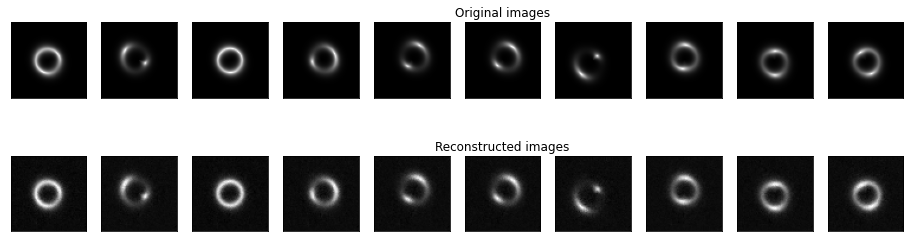

Epoch 12/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00030458741821348667, Val loss:0.00022942389477975667
Epoch 13/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00027381570544093847, Val loss:0.0002196967980125919
Epoch 14/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00026491537573747337, Val loss:0.00020026382117066532
Epoch 15/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00024982678587548435, Val loss:0.0002076573291560635
Epoch 16/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00023837314802221954, Val loss:0.00018190372793469578


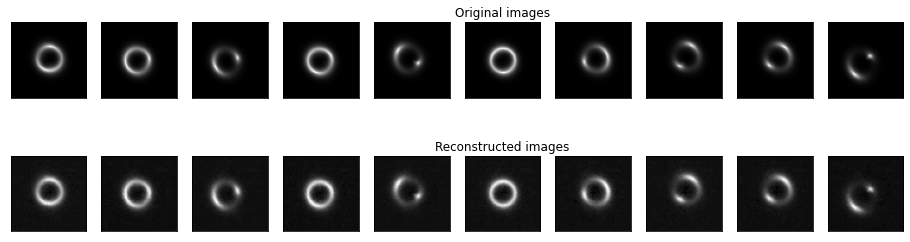

Epoch 17/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00022658673697151244, Val loss:0.00018502408056519926
Epoch 18/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00022238849487621337, Val loss:0.00015345268184319139
Epoch 19/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00020283124467823654, Val loss:0.0001728897332213819
Epoch 20/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00022027855447959155, Val loss:0.0001965557166840881
Epoch 21/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00019736922695301473, Val loss:0.00014248325896915048


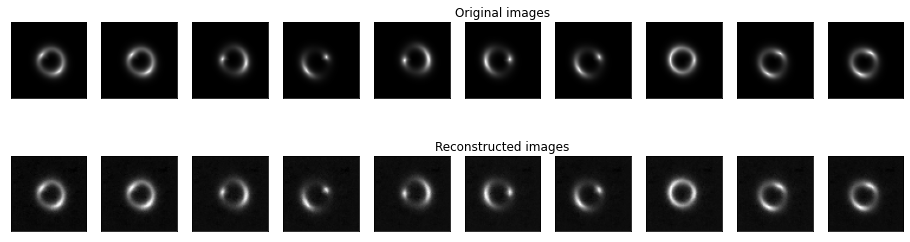

Epoch 22/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00018785773136187345, Val loss:0.00013668014435097575
Epoch 23/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00020559396944008768, Val loss:0.00011900789104402065
Epoch 24/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001730355288600549, Val loss:0.00017148828192148358
Epoch 25/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00018143105262424797, Val loss:0.0001352684193989262
Epoch 26/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00018063216703012586, Val loss:0.00019355869153514504


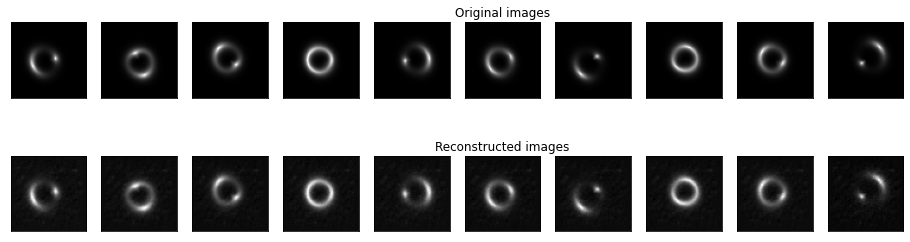

Epoch 27/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001681193825788796, Val loss:0.0001092458187486045
Epoch 28/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001771910028764978, Val loss:0.0002668945526238531
Epoch 29/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00015784254355821759, Val loss:0.0002505694283172488
Epoch 30/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001548873115098104, Val loss:0.00016450609837193042
Epoch 31/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001471321884309873, Val loss:0.00010622452828101814


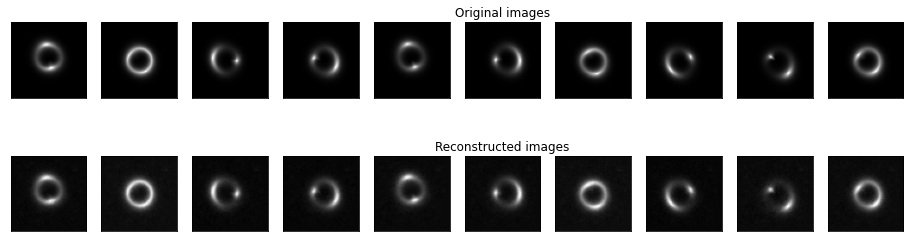

Epoch 32/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00016273645451292396, Val loss:0.00012776866788044572
Epoch 33/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013894934090785682, Val loss:0.00016342182061634958
Epoch 34/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00014872146130073816, Val loss:0.0001931226288434118
Epoch 35/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00015005600289441645, Val loss:0.0001060652793967165
Epoch 36/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00014982526772655547, Val loss:0.00010163936531171203


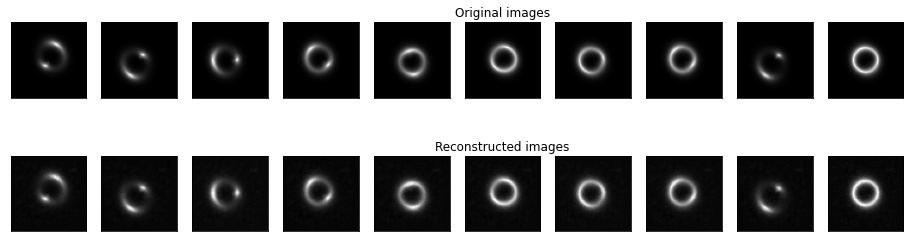

Epoch 37/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00014277294394560158, Val loss:0.00010879736510105431
Epoch 38/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012892059748992324, Val loss:0.00016842580225784332
Epoch 39/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001335978740826249, Val loss:8.591575169702992e-05
Epoch 40/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012685566616710275, Val loss:0.00013255802332423627
Epoch 41/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013165480049792677, Val loss:0.00015550843090750277


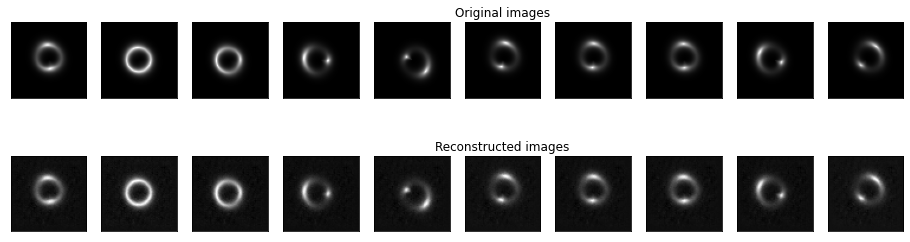

Epoch 42/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013000670878682286, Val loss:0.00010555828339420259
Epoch 43/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013481720816344023, Val loss:0.00015368714230135083
Epoch 44/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011998970876447856, Val loss:7.222360000014305e-05
Epoch 45/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011635968257905915, Val loss:8.923847053665668e-05
Epoch 46/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001276780676562339, Val loss:7.869542605476454e-05


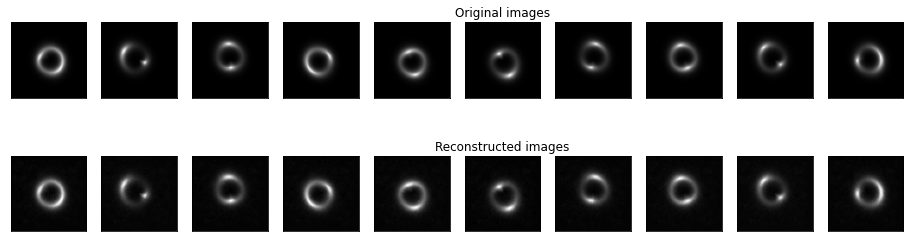

Epoch 47/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011466662544989958, Val loss:9.253513417206705e-05
Epoch 48/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011263146006967872, Val loss:7.168290903791785e-05
Epoch 49/100:


  0%|          | 0/109 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011022574472008273, Val loss:5.957111716270447e-05
Epoch 50/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011850379087263718, Val loss:0.0001511444424977526
Epoch 51/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010999728692695498, Val loss:0.00013293951633386314


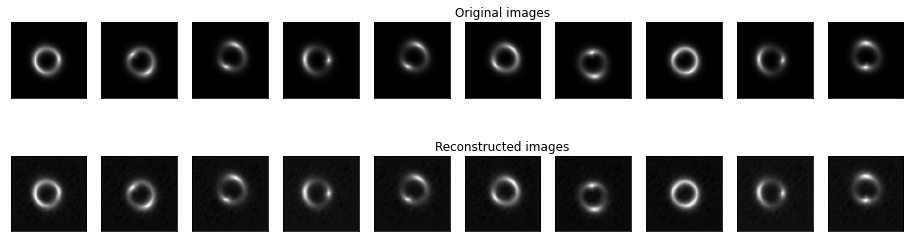

Epoch 52/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.985812357626855e-05, Val loss:0.00010270718485116959
Epoch 53/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011049724707845598, Val loss:8.097737736534327e-05
Epoch 54/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010244252916891128, Val loss:8.560260903323069e-05
Epoch 55/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010655255027813837, Val loss:9.20668535400182e-05
Epoch 56/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.722046524984762e-05, Val loss:7.69484686315991e-05


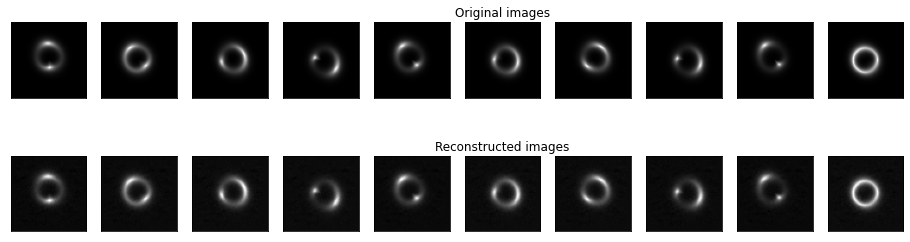

Epoch 57/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010387709335191175, Val loss:8.532926585758105e-05
Epoch 58/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.172362479148433e-05, Val loss:9.830012277234346e-05
Epoch 59/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.688906720839441e-05, Val loss:6.0802183725172654e-05
Epoch 60/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.396232781000435e-05, Val loss:0.0001014259469229728
Epoch 61/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.021227015182376e-05, Val loss:8.607883501099423e-05


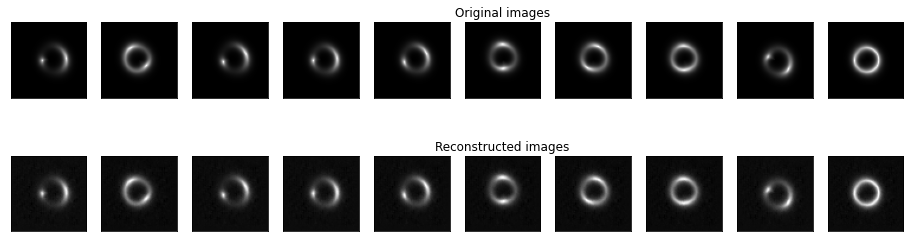

Epoch 62/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.182091889670119e-05, Val loss:6.496139394585043e-05
Epoch 63/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010163600381929427, Val loss:7.682076102355495e-05
Epoch 64/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.978056575870141e-05, Val loss:8.463842823402956e-05
Epoch 65/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.670346869621426e-05, Val loss:0.00010363569163018838
Epoch 66/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.362907828995958e-05, Val loss:0.000129598134662956


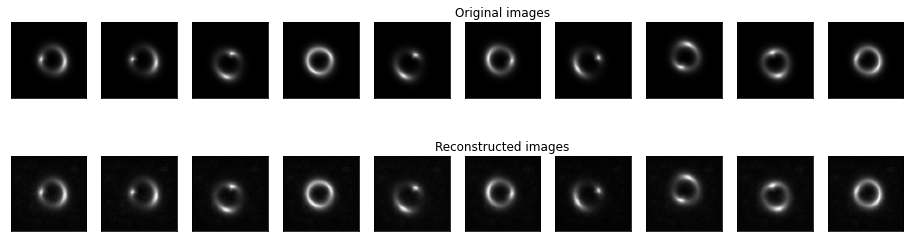

Epoch 67/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.703656203579158e-05, Val loss:6.09730341238901e-05
Epoch 68/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.131844126386568e-05, Val loss:0.00010166676656808704
Epoch 69/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.857920718379319e-05, Val loss:0.00011011373135261238
Epoch 70/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.819979459280148e-05, Val loss:6.765050056856126e-05
Epoch 71/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.283024362754077e-05, Val loss:8.427639841102064e-05


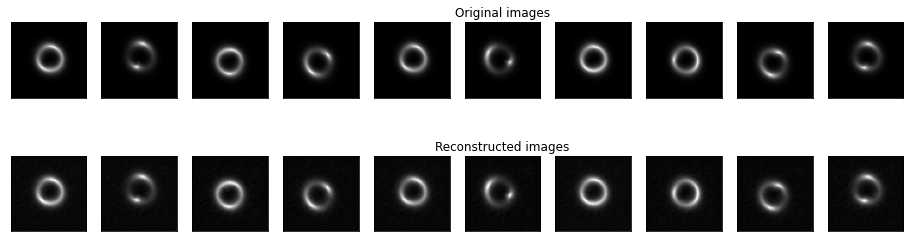

Epoch 72/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.298992179334164e-05, Val loss:6.248897989280522e-05
Epoch 73/100:


  0%|          | 0/109 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.180297638522461e-05, Val loss:5.515940210898407e-05
Epoch 74/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.195945363491774e-05, Val loss:6.896175182191655e-05
Epoch 75/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.34867314551957e-05, Val loss:5.269610483082943e-05
Epoch 76/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.800467235734686e-05, Val loss:6.076178033254109e-05


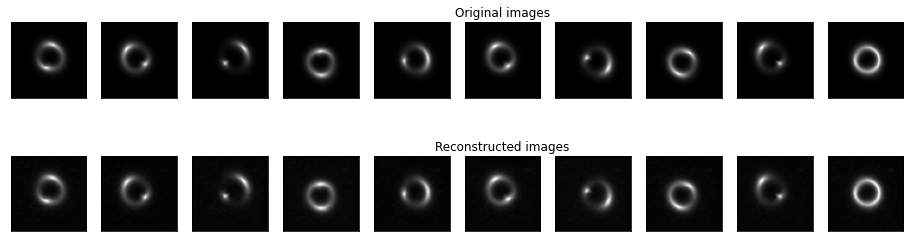

Epoch 77/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.693744555581361e-05, Val loss:8.350203279405832e-05
Epoch 78/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.73419815232046e-05, Val loss:7.223753345897421e-05
Epoch 79/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.382427429547533e-05, Val loss:6.320320244412869e-05
Epoch 80/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.657630729023367e-05, Val loss:6.245161785045639e-05
Epoch 81/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.088414713507518e-05, Val loss:0.00013953463349025697


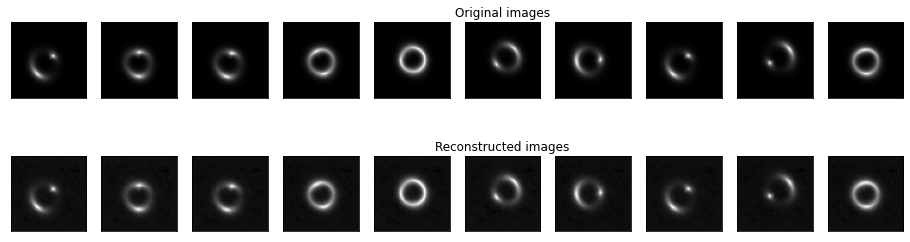

Epoch 82/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.114438631106168e-05, Val loss:3.7461508327396587e-05
Epoch 83/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.031214772723615e-05, Val loss:5.5618875194340944e-05
Epoch 84/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.526721699628979e-05, Val loss:5.644782868330367e-05
Epoch 85/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.941937317606062e-05, Val loss:7.054871821310371e-05
Epoch 86/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.495333218481392e-05, Val loss:4.020474443677813e-05


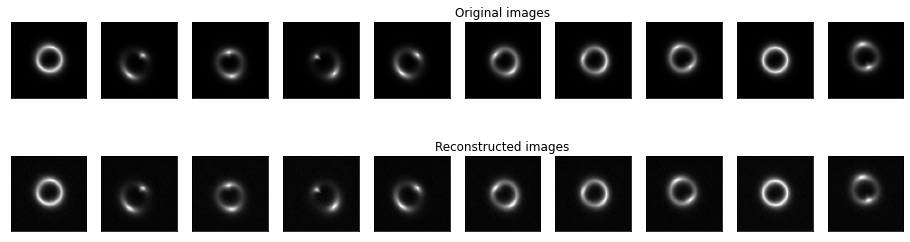

Epoch 87/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.586277595488355e-05, Val loss:6.582172500202432e-05
Epoch 88/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.325198384933174e-05, Val loss:5.0843460485339165e-05
Epoch 89/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.463641329901293e-05, Val loss:6.287208088906482e-05
Epoch 90/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.363294960465282e-05, Val loss:7.7109805715736e-05
Epoch 91/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.146936357254162e-05, Val loss:9.087155922316015e-05


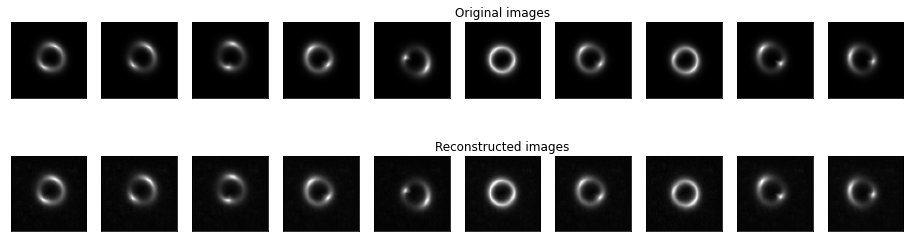

Epoch 92/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.001743506407365e-05, Val loss:5.189307194086723e-05
Epoch 93/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.415493407985196e-05, Val loss:7.051281863823533e-05
Epoch 94/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.196026515681297e-05, Val loss:4.4603079004446045e-05
Epoch 95/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.348917668219656e-05, Val loss:9.06915811356157e-05
Epoch 96/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:5.765672540292144e-05, Val loss:8.182788587873802e-05


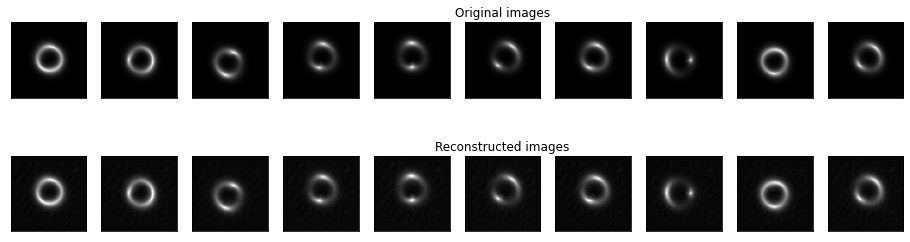

Epoch 97/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:6.49583525955677e-05, Val loss:4.427749081514776e-05
Epoch 98/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:5.937416426604614e-05, Val loss:5.255961150396615e-05
Epoch 99/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:5.883377161808312e-05, Val loss:4.747114871861413e-05
Epoch 100/100:


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:5.770743518951349e-05, Val loss:4.3573236325755715e-05


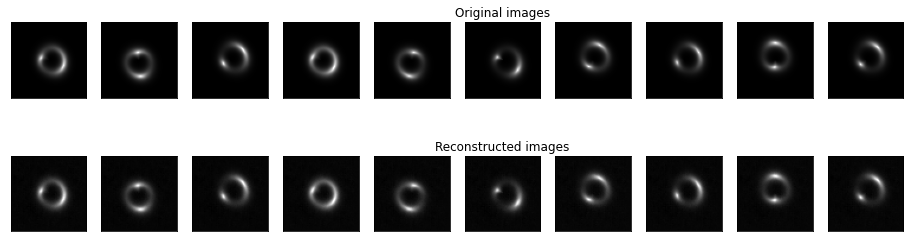

In [26]:
#Training and tracking model
model, loss_dict = fit_model(model, config)

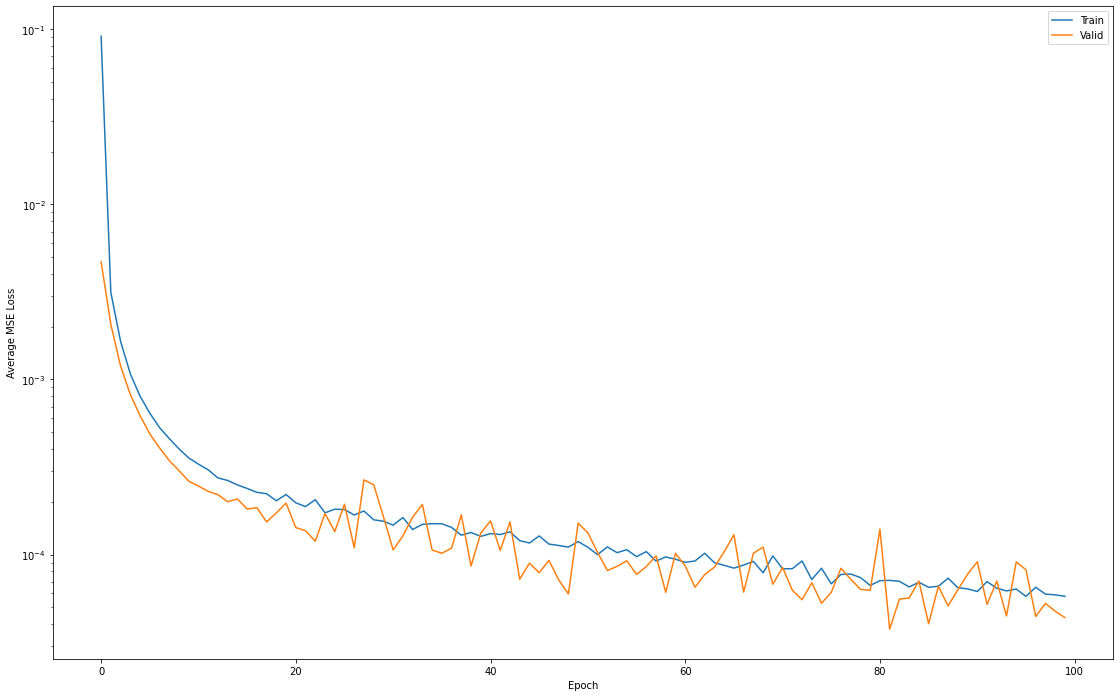

In [27]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
#plt.grid()
plt.legend()
#plt.title('loss')


plot_name = "Loss_history"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)
wandb.log({plot_name: [wandb.Image(pic, caption = f"Train, Val MSE loss history")]})

plt.show()

In [28]:
PATH = "conv_AE.pth"
torch.save(model.state_dict(), PATH)

In [29]:
del model
gc.collect()

model = Autoencoder().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
criterion = nn.MSELoss()

_, _, train_mse = test_epoch(model, train_loader, criterion)
print("Train set MSE:" + str(train_mse))

_, _, val_mse = test_epoch(model, val_loader, criterion)
print("Val set MSE:" + str(val_mse))

_, _, test_mse = test_epoch(model, test_loader, criterion)
print("Test set MSE:" + str(test_mse))

  0%|          | 0/109 [00:00<?, ?it/s]

Train set MSE:4.8670314e-05


  0%|          | 0/9 [00:00<?, ?it/s]

Val set MSE:4.3573236e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Test set MSE:4.35242e-05


In [31]:
scores = [[train_mse, val_mse, test_mse]]

wandb.log({"MSE_Scores": wandb.Table(data = scores, columns=["Train_MSE", "Val_MSE", "Test_MSE"])})

## Model Testing

In [32]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    class_map = {}
    class_distribution = {}
    
    for img_path in root_list:
        class_name = img_path.split(os.sep)[-2]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] +=1
                
    for index, entity in enumerate(class_distribution):
        class_map[entity] = index
    print("Dataset Distribution:\n")
    print(class_distribution)
    print("\n\nClass indices:\n")
    print(class_map)

    data = []
    for img_path in tqdm(root_list):
        class_name = img_path.split(os.sep)[-2]
        data.append([img_path, class_name])
        
    return data, class_map

In [33]:
test_data_root_dir = r'../input/gsocml4scimodel3test/Model_III_test/*/*'
test_dataset_img_paths_list, class_map = img_paths_list(test_data_root_dir)

Dataset Distribution:

{'axion': 5000, 'no_sub': 5000, 'cdm': 5000}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/15000 [00:00<?, ?it/s]

In [34]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        img = (img - np.min(img))/(np.max(img) - np.min(img))
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

In [35]:
test_dataset = CustomDataset(test_dataset_img_paths_list, class_map, transform = test_transforms)
print(len(test_dataset))

15000


In [36]:
test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)

In [37]:
single_batch = next(iter(test_loader))
single_batch[0].shape

torch.Size([256, 1, 64, 64])

In [38]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    losses = []
    
    truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch, class_ids) in loop:
            
            for img in img_batch:
                img = img.unsqueeze(0)
                X = img.to(device)
                recon = model(X)
                loss = criterion(recon, X)
                losses.append(loss.detach().cpu().numpy())
            
            
            for class_id in class_ids:
                if class_id == class_map['no_sub']:
                    truth_list.append(0)
                else:
                    truth_list.append(1)


            
    return np.asarray(losses), np.asarray(truth_list), np.mean(losses)

In [39]:
criterion = nn.MSELoss()
loss_list, truth_list, mean_loss = test_epoch(model, test_loader,criterion)
print(mean_loss)

  0%|          | 0/59 [00:00<?, ?it/s]

0.000105388564


In [40]:
fpr, tpr, thresholds = roc_curve(truth_list, loss_list)
roc_auc = auc(fpr, tpr)

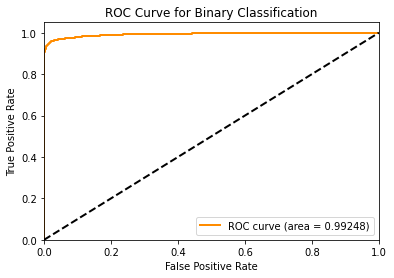

In [41]:
# Plot the AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right", prop={"size":10})

plot_name = "ROC-AUC"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)
wandb.log({plot_name: [wandb.Image(pic, caption = f"ROC-AUC curve")]})

plt.show()

In [42]:
wandb.finish()